In [1]:
%run base.ipynb

In [2]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
# import casadi as ca
from diffUV import MarineVehicleEstimator 
from custom_plots import plot_dof_matrix, pretty_print_vehicle_params
# Y = ca.Function.load("models/vehicle_id_Y.casadi") # vehicle model regressor for system id

In [3]:
Y , YMC, YG, YD, lumped_params, inertia_mat_id, C_id, g_id, body_damping_matrix_id = uv_body.build_sys_regressor()
tau_id = Y@lumped_params

# lambdify API to (x)->(Y)
Y_reg = ca.Function('Y_reg_cs',[eul, x_nb, dx_nb, v_c],[Y])
Y_reg.save('vehicle_id_Y.casadi')

In [4]:
tau_id_fun = ca.Function("affine_form", [eul, x_nb, dx_nb, v_c, lumped_params, f_ext], [tau_id - f_ext])
f_phi_tau_fun = ca.Function("f_of_x_form", [eul, x_nb, dx_nb, sim_p, f_ext], [tau_id_fun(eul, x_nb, dx_nb, v_c, beta_sym, f_ext)])

In [5]:
blue_eul = np.array([0.1, 0.2, 0.3]) # example euler angles
v_0 = np.array([0.1 ,0.2,0.1,0.1,0.1,0.5]) # example velocity vector
a_0 = np.array([0.1 ,0.2,0.9,0.0,1.0,0.0]) # example acceleration vector
f_ext_0 = np.array([0.0 ,0.0,0.0,1.1,0.0,0.0]) # example force vector

f_phi_tau_fun(blue_eul, v_0, a_0, blue.sim_params, f_ext_0)

DM([-0.0273586, 7.74542, 26.596, -0.874536, 0.662358, 0.5665])

In [6]:
tau = uv_body.body_inverse_dynamics()
f_x_tau = ca.Function("f_x", [z, eul, x_nb, dx_nb, sim_p, f_ext], [tau])
f_x_tau(blue.below_surface, blue_eul, v_0, a_0, blue.sim_params, f_ext_0)

DM([-0.0273586, 7.74542, 26.596, -0.874536, 0.662358, 0.5665])

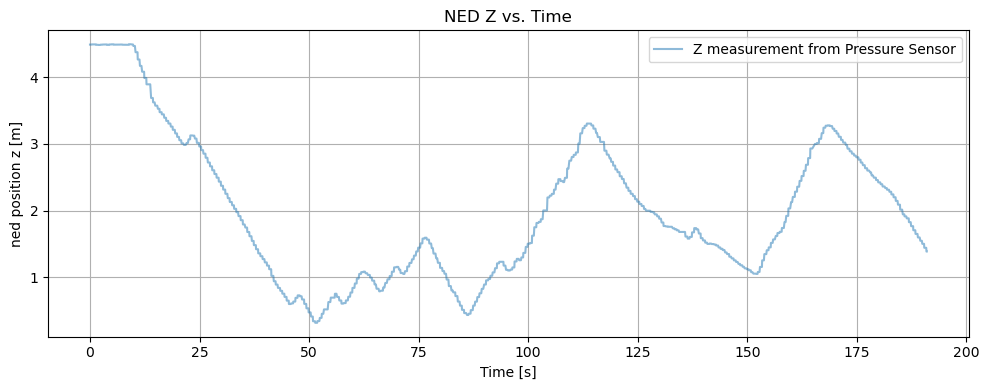

In [7]:
# Import CSV data into a DataFrame
df = pd.read_csv("sample_data/best_data/20250914_152115/20250914_152115_robot_real_.csv")

# df = pd.read_csv("data/best_data/20250914_152432/20250914_152432_robot_real_.csv")

# Compute time difference (dt) between consecutive timestamps
df = df.assign(dt=df['timestamp'].shift(-1) - df['timestamp'])

# Set the last row's dt to 0 since it has no next timestamp
df.loc[df.index[-1], 'dt'] = 0.0

# Remove rows where dt == 0 (e.g., the last row) and reset index
df = df[df['dt'] != 0].reset_index(drop=True)

# truncate the data to a smaller time window for visualization and system identification
# df = df.iloc[60:2250].reset_index(drop=True)

# Extract time-step series for convenience
dt = df['dt']
t = df['timestamp'].to_numpy(dtype=float)

# Unwrap IMU Euler angles to prevent discontinuities from wrapping (e.g., -pi to pi)
# Negate pitch and yaw to match measurement sign conventions
imu_roll_unwrapped  = df['imu_roll_unwrap']
imu_pitch_unwrapped = -df['imu_pitch_unwrap']
imu_yaw_unwrapped   = -df['imu_yaw_unwrap']

# imu_ang_vel_x   = df['imu_ang_vel_x']
# imu_ang_vel_y   = -df['imu_ang_vel_y']
# imu_ang_vel_z   = -df['imu_ang_vel_z']

dvl_x   = df['dvl_speed_x']
dvl_y   = df['dvl_speed_y']
dvl_z   = df['dvl_speed_z']

# vel_imu_roll = imu_ang_vel_x
# vel_imu_pitch = imu_ang_vel_y
# vel_imu_yaw = imu_ang_vel_z

# Compute angular velocities for IMU angles
vel_imu_roll  = np.gradient(imu_roll_unwrapped, df['timestamp'])
vel_imu_pitch = np.gradient(imu_pitch_unwrapped, df['timestamp'])
vel_imu_yaw   = np.gradient(imu_yaw_unwrapped, df['timestamp'])

window_length = 35  # adjust as needed based on your data length
polyorder = 2

# Smooth the IMU angular velocities using the Savitzky–Golay filter
droll  = savgol_filter(vel_imu_roll, window_length, polyorder)
dpitch = savgol_filter(vel_imu_pitch, window_length, polyorder)
dyaw   = savgol_filter(vel_imu_yaw, window_length, polyorder)

def inv_angular_vel_T(eul):
    phi, thet, psi = eul[0],eul[1],eul[2]
    T_1 = np.eye(3)
    T_1[0,2] = -np.sin(thet)
    T_1[1,1] = np.cos(phi)
    T_1[1,2] = np.cos(thet)*np.sin(phi)
    T_1[2,1] = -np.sin(phi)
    T_1[2,2] = np.cos(thet)*np.cos(phi)
    return T_1

body_vel = np.array([
    [u, v, w] + (inv_angular_vel_T((phi, thet, psi))@np.array([dphi, dthet, dpsi])).tolist()
    for u, v, w, phi, thet, psi, dphi, dthet, dpsi in zip(dvl_x, dvl_y, dvl_z,
                                                 imu_roll_unwrapped, imu_pitch_unwrapped, imu_yaw_unwrapped , droll, dpitch, dyaw)
])

body_vel = savgol_filter(body_vel, window_length, polyorder, 0, 1, 0)
body_acc = np.gradient(body_vel, t, axis=0, edge_order=2)
body_acc = savgol_filter(body_acc, window_length, polyorder, 0, 1, 0)


plt.figure(figsize=(10, 4))
plt.plot(df['timestamp'], df['depth_from_pressure2'], label='Z measurement from Pressure Sensor', alpha=0.5)
plt.xlabel('Time [s]')
plt.ylabel('ned position z [m]')
plt.title('NED Z vs. Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Build dicts for u v w p q r
series_vel = {
    "u": body_vel[:,0],
    "v": body_vel[:,1],
    "w": body_vel[:,2],
    "p": body_vel[:,3],
    "q": body_vel[:,4],
    "r": body_vel[:,5],
}

series_acc = {
    "u": body_acc[:,0],
    "v": body_acc[:,1],
    "w": body_acc[:,2],
    "p": body_acc[:,3],
    "q": body_acc[:,4],
    "r": body_acc[:,5],
}
series_in = {
    "u": df['base_x_force'].to_numpy(),
    "v": df['base_y_force'].to_numpy(),
    "w": df['base_z_force'].to_numpy(),
    "p": df['base_x_torque'].to_numpy(),
    "q": df['base_y_torque'].to_numpy(),
    "r": df['base_z_torque'].to_numpy(),
}

colors = plt.get_cmap("tab10").colors
dof_colors = {
    "u": colors[0],  # blue
    "v": colors[1],  # orange
    "w": colors[2],  # green
    "p": colors[3],  # red
    "q": colors[4],  # purple
    "r": colors[5],  # brown
}

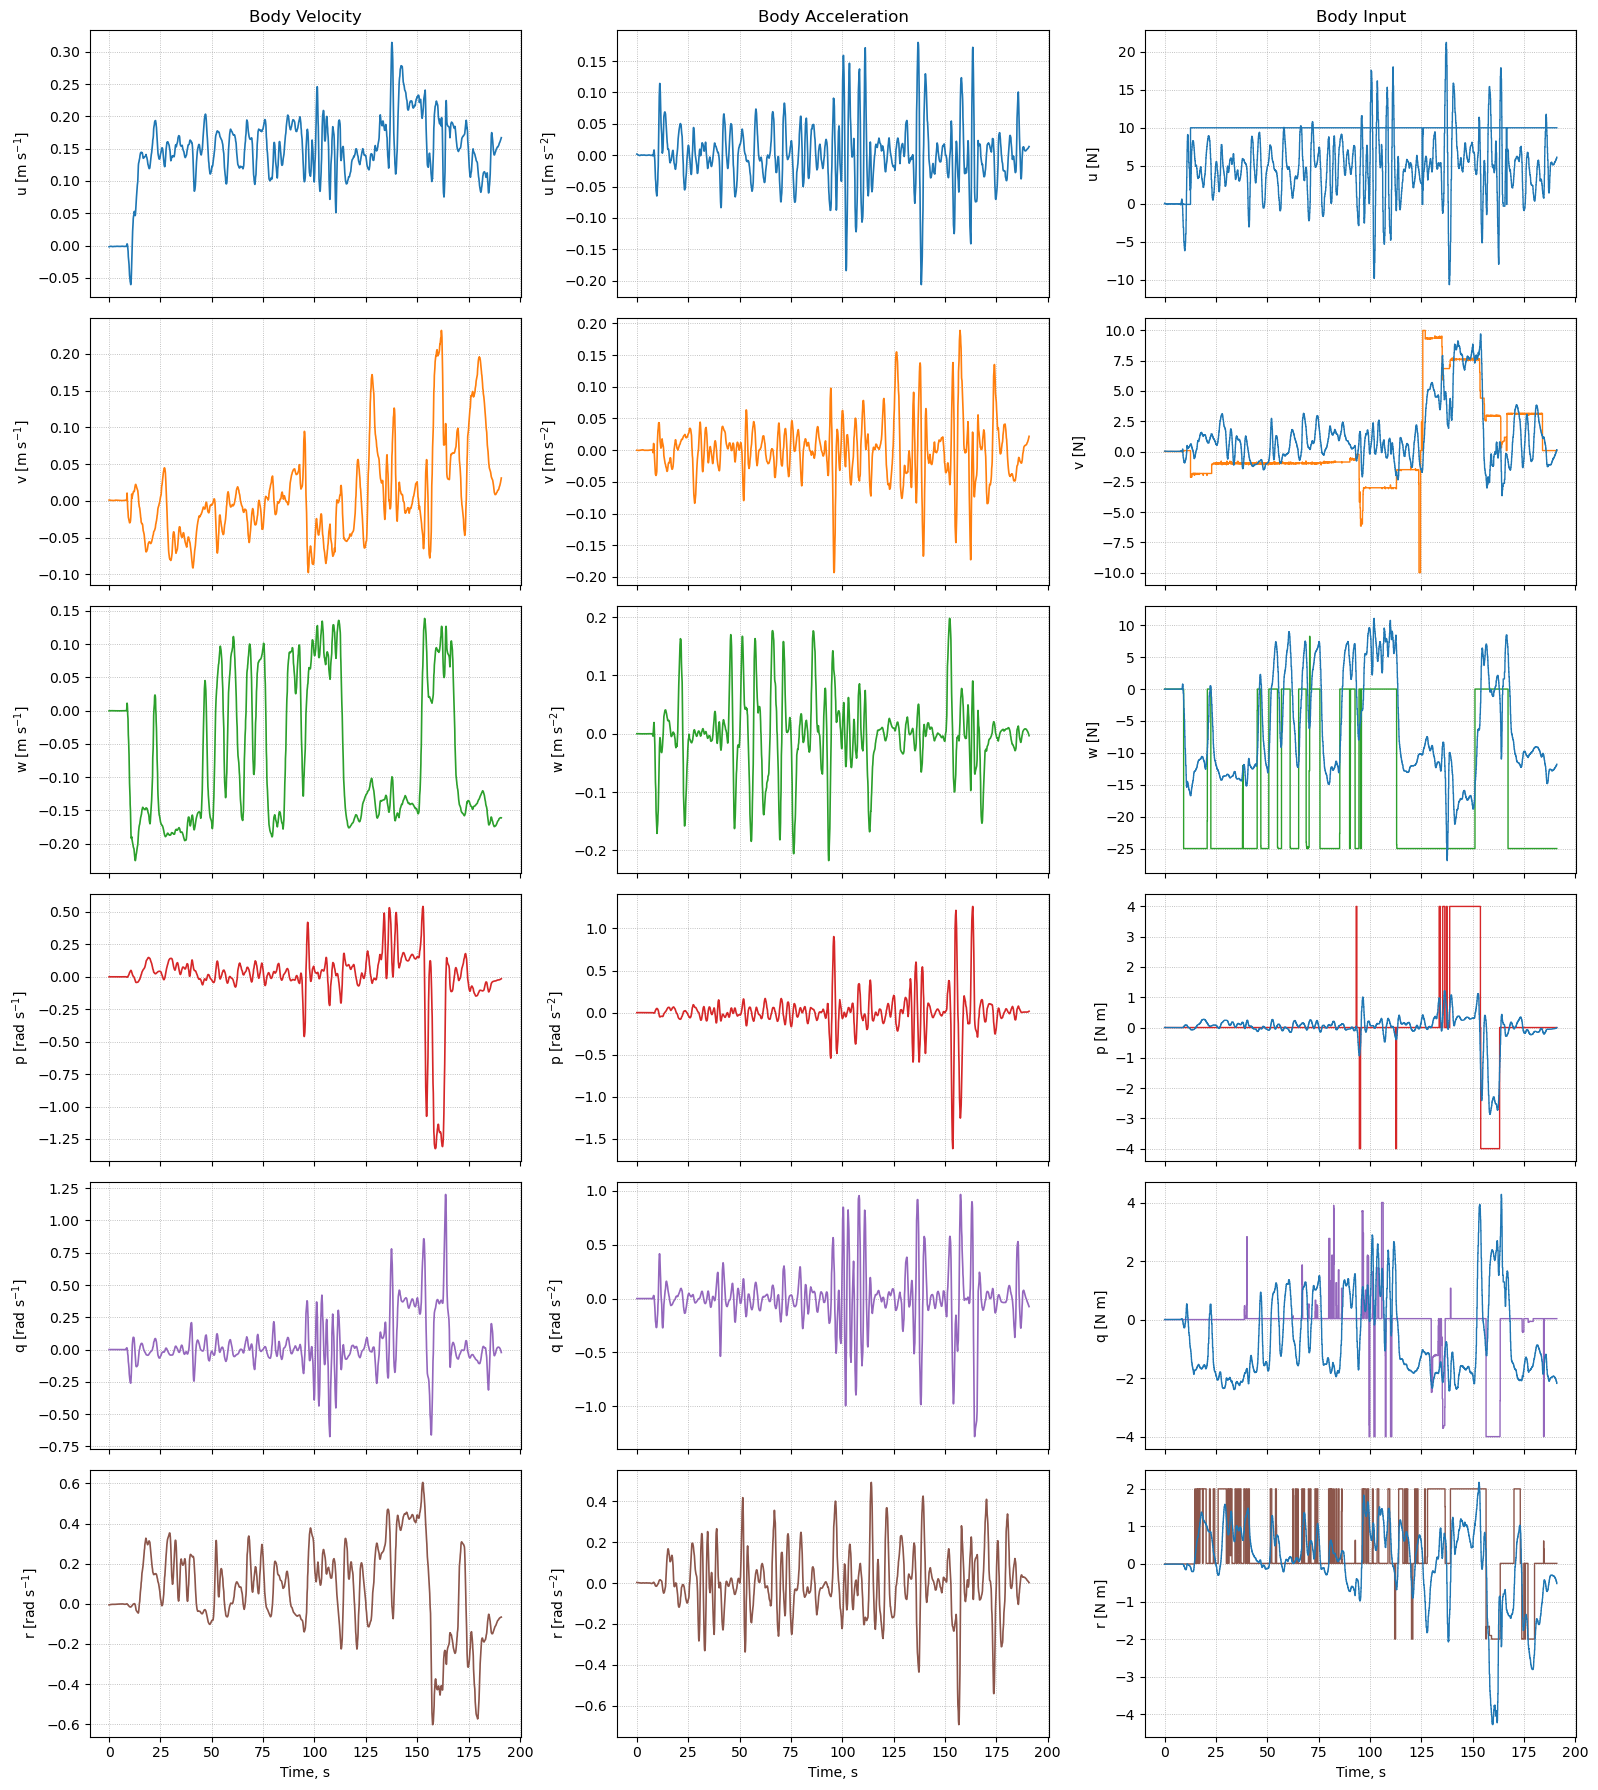

In [9]:
# Evaluate the regressor at each time
# Y(eul, x_nb, dx_nb, v_c)
# Y should map, per sample, from theta to tau_sample, size 4 x p
τ_rows = []
v_c = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # current velocity in world frame, assumed known
# np.array([m_X_du, m_Y_dv, m_Z_dw,
#             mz_g_X_dq, _mz_g_Y_dp, _mz_g_K_dv, mz_g_M_du, 
            
#             I_x_K_dp, I_y_M_dq, I_z_N_dr, 
#              W_, B_, x_gW_x_bB, y_gW_y_bB , z_gW_z_bB, 
#              X_u_,Y_v_,Z_w_,K_p_,M_q_,N_r_, 
#               X_uu_,Y_vv_,Z_ww_,K_pp_,M_qq_,N_rr_])
m_X_du, m_Y_dv, m_Z_dw = 80, 5, 2
I_x_K_dp, I_y_M_dq, I_z_N_dr = 0.5, 0.5, 0.5
initial_thet = np.array([m_X_du, m_Y_dv, m_Z_dw,
                0.0, 0.0, 0.0, 0.0, 
                I_x_K_dp, I_y_M_dq, I_z_N_dr, 
                 0, 0, 0, 0 , 0, 
                 -30,-30,-75,-2,-2,-2, 
                 0,0,0,0,0,0])

# m_X_du, m_Y_dv, m_Z_dw = 1.50283130e+01,  1.45300709e+01,  2.18956131e+01
# I_x_K_dp, I_y_M_dq, I_z_N_dr = 7.53156533e-01, 8.52997715e-01,  8.75770334e-01
# initial_thet = np.array([m_X_du, m_Y_dv, m_Z_dw,
#                 -9.19820573e-01, 1.07543652e+00,  1.07543652e+00, -9.19820573e-01,  
#                 I_x_K_dp, I_y_M_dq, I_z_N_dr, 
#                  1.74203087e+00, -1.74203087e+00, 6.54185143e-01, -6.29265196e-03, 4.16195921e+00, 
#                  -7.60792156e+01, -3.69375684e+01, -8.11049040e+01, -1.39990183e+00, -1.38053725e+00, -3.08965906e+00,
#                  2.44739743e+01, -3.90753249e+00,  2.50969042e+01, -3.00553283e-01,  2.94970568e-01,  1.55803496e+00])
for k in range(imu_roll_unwrapped.shape[0]):
    eul = [
        imu_roll_unwrapped[k],
        imu_pitch_unwrapped[k],
        imu_yaw_unwrapped[k]
    ]
    x_nb = [
        series_vel['u'][k],
        series_vel['v'][k],
        series_vel['w'][k],
        series_vel['p'][k],
        series_vel['q'][k],
        series_vel['r'][k]
    ]
    dx_nb = [
        series_acc['u'][k],
        series_acc['v'][k],
        series_acc['w'][k],
        series_acc['p'][k],
        series_acc['q'][k],
        series_acc['r'][k]
    ]
    Yk = Y_reg(eul, x_nb, dx_nb, v_c)  # CasADi return, expected shape 6 x p
    Yk = np.array(Yk, dtype=float)  # to numpy
    τ_row = Yk@initial_thet
    τ_rows.append(τ_row)
τ_rows = np.array(τ_rows)

plot_dof_matrix(t, series_vel, series_acc, series_in, τ_rows, colors=dof_colors, step_inputs=True)



In [11]:
τ_rows = []
Y_rows = []
x_nb_s = []
v_c = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # current velocity in world frame, assumed known
for k in range(imu_roll_unwrapped.shape[0]):
    eul = [
        imu_roll_unwrapped[k],
        imu_pitch_unwrapped[k],
        imu_yaw_unwrapped[k]
    ]
    x_nb = [
        series_vel['u'][k],
        series_vel['v'][k],
        series_vel['w'][k],
        series_vel['p'][k],
        series_vel['q'][k],
        series_vel['r'][k]
    ]
    dx_nb = [
        series_acc['u'][k],
        series_acc['v'][k],
        series_acc['w'][k],
        series_acc['p'][k],
        series_acc['q'][k],
        series_acc['r'][k]
    ]
    Yk = Y_reg(eul, x_nb, dx_nb, v_c)  # CasADi return, expected shape 6 x p
    Yk = np.array(Yk, dtype=float)  # to numpy
    tk = np.array([
        series_in['u'][k],
        series_in['v'][k],
        series_in['w'][k],
        series_in['p'][k],
        series_in['q'][k],
        series_in['r'][k]
    ]).reshape(-1, 1)   # 4 x 1

    Y_rows.append(Yk)               # 6 x p
    τ_rows.append(tk)             # 6 x 1
    x_nb_s.append(x_nb)

# Tall stack, size (4T x p) and (4T x 1)
Y_big = np.vstack(Y_rows)
τ_big = np.vstack(τ_rows).ravel()

n_horizon = len(Y_rows)
n_params  = Y_big.shape[1]
estimator  = MarineVehicleEstimator(6, n_params, n_horizon, initial_thet, x_nb_s)

In [12]:
theta_hat, v, w, solve_time = estimator.estimate_vehicle_physical_parameters(Y_big, τ_big, True)
print(solve_time)

0.15360888600116596


In [13]:
theta_hat, v, w, solve_time = estimator.estimate_vehicle_physical_parameters(Y_big, τ_big, True)
print(solve_time)

0.1383005259995116


In [14]:
theta_hat, v, w, solve_time = estimator.estimate_vehicle_physical_parameters(Y_big, τ_big, True)
print(solve_time)

0.1340018240007339


In [15]:
M_est = estimator.M_from_uv(theta_hat).value
v_r_0 = np.array([0.1 ,0.2,0.1,0.1,0.1,0.5]) # example velocity vector
C_est = estimator.coriolis_cvxpy(M_est, v_r_0).value

print(-C_est.T == C_est)

print(np.allclose(M_est, M_est.T, atol=1e-9))

[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]]
True


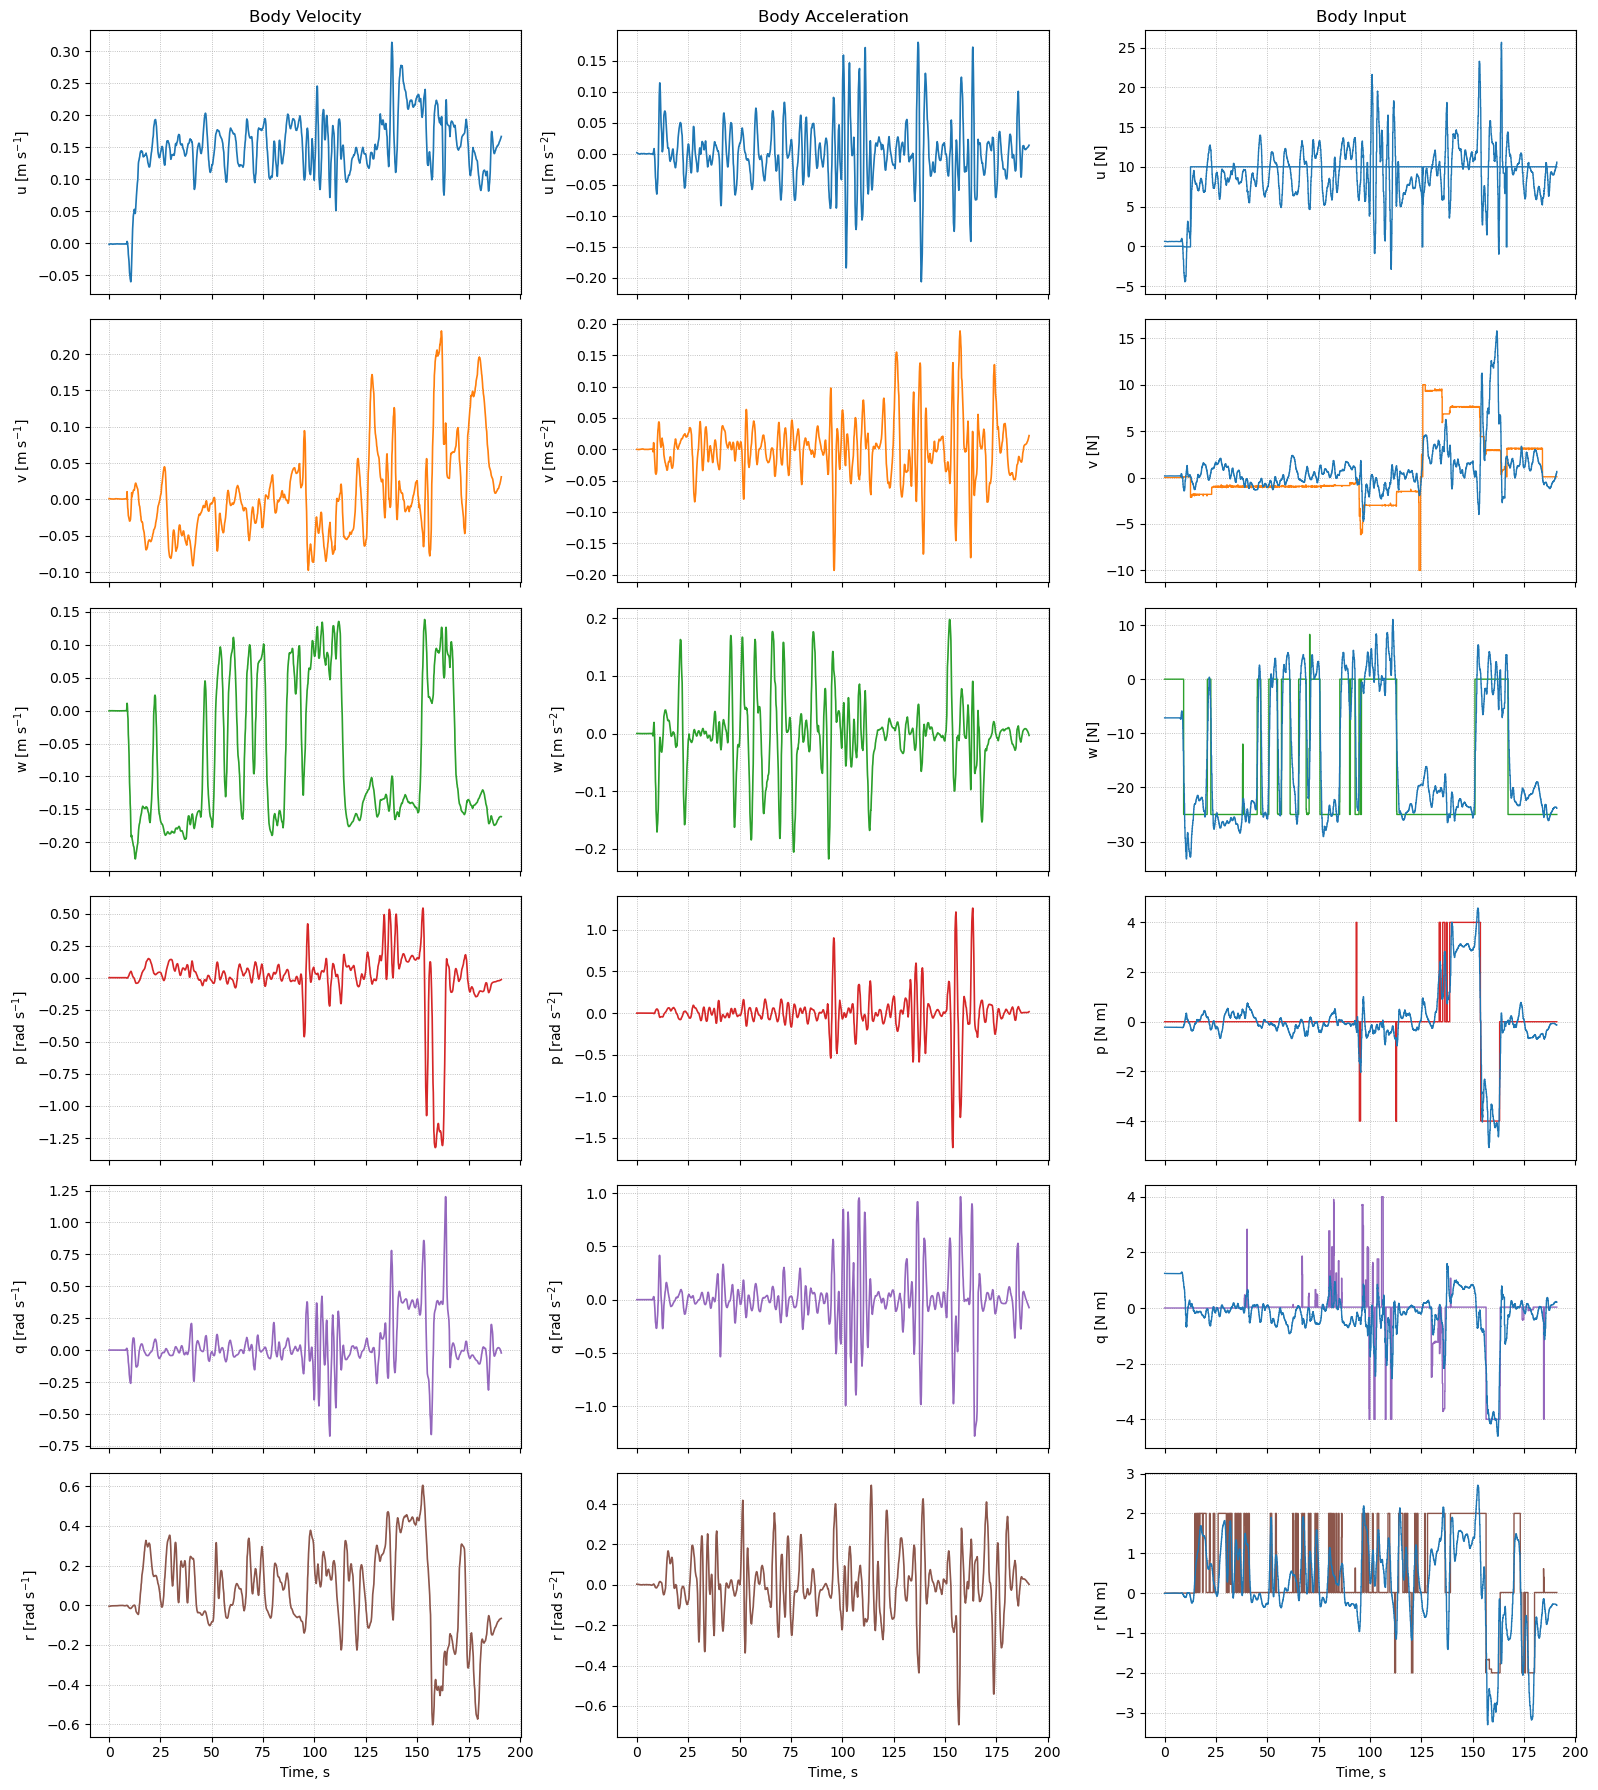

In [18]:
# Evaluate the regressor at each time
# Y(eul, x_nb, dx_nb, v_c)
# Y should map, per sample, from theta to tau_sample, size 4 x p
τ_rows = []
v_c = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # current velocity in world frame, assumed known
for k in range(imu_roll_unwrapped.shape[0]):
    eul = [
        imu_roll_unwrapped[k],
        imu_pitch_unwrapped[k],
        imu_yaw_unwrapped[k]
    ]
    x_nb = [
        series_vel['u'][k],
        series_vel['v'][k],
        series_vel['w'][k],
        series_vel['p'][k],
        series_vel['q'][k],
        series_vel['r'][k]
    ]
    dx_nb = [
        series_acc['u'][k],
        series_acc['v'][k],
        series_acc['w'][k],
        series_acc['p'][k],
        series_acc['q'][k],
        series_acc['r'][k]
    ]
    Yk = Y_reg(eul, x_nb, dx_nb, v_c)  # CasADi return, expected shape 6 x p
    Yk = np.array(Yk, dtype=float)  # to numpy
    τ_row = Yk@theta_hat
    # τ_row = Yk@initial_thet
    τ_rows.append(τ_row)
τ_rows = np.array(τ_rows)

plot_dof_matrix(t, series_vel, series_acc, series_in, τ_rows, colors=dof_colors, step_inputs=True)

In [19]:
_ = pretty_print_vehicle_params(theta_hat, title="Identified vehicle parameters, UVMS base")


Identified vehicle parameters, UVMS base
----------------------------------------------------

Effective translational inertia terms, linear velocity axes:
  surge, m - X_du: 37.2029
  sway,  m - Y_dv: 22.1828
  heave, m - Z_dw: 66.1735

Effective rotational inertia terms, angular velocity axes:
  roll,  I_x - K_dp: 1.39646
  pitch, I_y - M_dq: 0.498032
  yaw,   I_z - N_dr: 2.53119

Restoring terms:
  weight W [N]: 105
  buoyancy B [N]: 97.8296
  net, B - W [N]: -7.17035
  x_g W - x_b B [N m]: 0.82748
  y_g W - y_b B [N m]: 0.136823
  z_g W - z_b B [N m]: 4.25841
  ||[x_g W - x_b B, y_g W - y_b B, z_g W - z_b B]||: 4.34022

Linear drag coefficients:
  X_u [N s m^-1]: -73.6417
  Y_v [N s m^-1]: -33.6082
  Z_w [N s m^-1]: -89.4055
  K_p [N m s rad^-1]: -2.98736
  M_q [N m s rad^-1]: -1.57922
  N_r [N m s rad^-1]: -3.39766

Quadratic drag coefficients:
  X_uu [N s^2 m^-2]: -0.000147912
  Y_vv [N s^2 m^-2]: -0.000516373
  Z_ww [N s^2 m^-2]: -98.5523
  K_pp [N m s^2 rad^-2]: -0.0305908
  M